In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler


from sklearn.metrics import recall_score, accuracy_score, precision_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

import fairlearn.metrics as flm
from fairlearn.reductions import DemographicParity, ExponentiatedGradient
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import selection_rate
from fairlearn.postprocessing import ThresholdOptimizer

In [36]:
def categorize_age(age):
    if age < 1:
        if 0 <= age <= 0.18:
            return "18-30"
        elif 0.18 < age <= 0.58:
            return "30-60"
        else:
            return "60-99"
    else:
        if 10<= age <= 30:
            return "18-30"
        elif 30 < age <= 60:
            return "30-60"
        else:
            return "60-99"
"""categorizes the age in three classes"""

def remove_sensitive_features(dataset, remove, not_removed, features, categorizer="age"):
    for item in remove:
        if item in not_removed:
            not_removed.remove(item)

    decoded_sensitive_features = None

    if categorizer in not_removed:
        dataset["Age_Category"] = dataset[categorizer].map(categorize_age)
        
        # Copy the desired columns into decoded_sensitive_features
        decoded_sensitive_features = dataset.loc[:, not_removed].copy()

        # Add the "Age_Category" column from "dataset" to decoded_sensitive_features
        decoded_sensitive_features[categorizer] = dataset["Age_Category"]

        # Remove the "Age_Category" column from the original "dataset"
        dataset.drop("Age_Category", axis=1, inplace=True)
    else:
        decoded_sensitive_features = dataset.loc[:, not_removed].copy()

    if 'sex' in not_removed:
        decoded_sensitive_features['sex'] = decoded_sensitive_features['sex'].replace({0.0: ' Female', 1.0: ' Male'})
    if 'race' in not_removed:
        decoded_sensitive_features['race'] = decoded_sensitive_features['race'].replace({0: ' White', 1: ' Other'})
 
    removable = []
    for feature in remove:
        if feature in features:
            features.remove(feature)
            removable.append(feature)
            
    dataset.drop(removable, axis=1, inplace=True)

    return dataset, decoded_sensitive_features
"""removes sensitive features from dataset and creates decoded_sensitive_features for fairness metrics"""

'removes sensitive features from dataset and creates decoded_sensitive_features for fairness metrics'

In [37]:
df_adult = (pd.read_csv("adult.csv").drop(columns=["fnlwgt", "relationship", "education"]))
print(f"The dataset contains {df_adult.shape[0]} data points and {df_adult.shape[1]} features.")
df_adult.head()

The dataset contains 32561 data points and 12 features.


,age,workclass,education.num,marital.status,occupation,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,9,Widowed,?,White,Female,0,4356,40,United-States,<=50K
1,82,Private,9,Widowed,Exec-managerial,White,Female,0,4356,18,United-States,<=50K
2,66,?,10,Widowed,?,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,4,Divorced,Machine-op-inspct,White,Female,0,3900,40,United-States,<=50K
4,41,Private,10,Separated,Prof-specialty,White,Female,0,3900,40,United-States,<=50K


<h2>Data Preprocessing<h2>

In [38]:
# Analyze which features has missing value (?)
missing_values = df_adult.isin(["?"]).sum()
print(f"Missing values in the dataset: \n{missing_values}")

print("\n")

# Print rows with missing values
print("Rows with missing values: ")
print(df_adult[(df_adult == "?").any(axis=1)])


Missing values in the dataset: 
age                  0
workclass         1836
education.num        0
marital.status       0
occupation        1843
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64


Rows with missing values: 
       age workclass  education.num      marital.status         occupation  \
0       90         ?              9             Widowed                  ?   
2       66         ?             10             Widowed                  ?   
9       41   Private             10       Never-married       Craft-repair   
14      51         ?             16       Never-married                  ?   
18      22   Private             12       Never-married  Handlers-cleaners   
...    ...       ...            ...                 ...                ...   
32533   35         ?             13  Married-civ-spouse                  ?   
32534   30         ?      

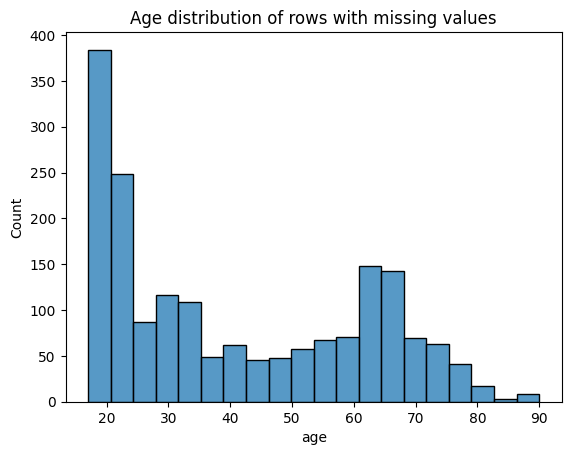

In [39]:
# Analyze age distribution of only rows with ? in workclass and occupation with histogramm
df_adult["age"] = pd.to_numeric(df_adult["age"])
df_adult["workclass"] = df_adult["workclass"].replace("?", np.nan)
df_adult["occupation"] = df_adult["occupation"].replace("?", np.nan)
df_adult_missing = df_adult[(df_adult["workclass"].isna()) & (df_adult["occupation"].isna())]
sns.histplot(data=df_adult_missing, x="age", bins=20)
plt.title("Age distribution of rows with missing values")
plt.show()


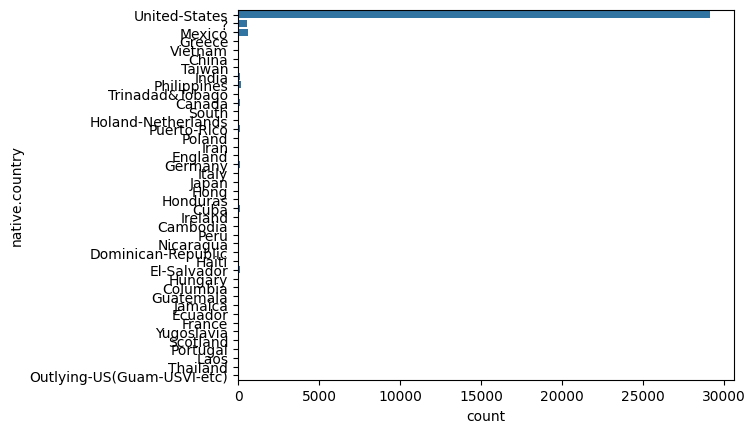

In [40]:
# Replace NaNs in workclass with "Private" and in occupation with "Unknown"
df_adult["workclass"] = df_adult["workclass"].replace(np.nan, "Private")
df_adult["occupation"] = df_adult["occupation"].replace(np.nan, "Unknown")

# Show distribution of native country
sns.countplot(data=df_adult, y="native.country")

# Replace missing values in native country with "United-States"
df_adult["native.country"] = df_adult["native.country"].replace("?", "United-States")




In [41]:
# Get description of dataset
print(df_adult.describe())

# Replace values with 99999 in capital gain and hours per week with mean
df_adult["capital.gain"] = df_adult["capital.gain"].replace(99999, df_adult["capital.gain"].mean())
df_adult["hours.per.week"] = df_adult["hours.per.week"].replace(99, df_adult["hours.per.week"].mean())

# Get description of dataset
print(df_adult.describe())

                age  education.num  capital.gain  capital.loss  hours.per.week
count  32561.000000   32561.000000  32561.000000  32561.000000    32561.000000
mean      38.581647      10.080679   1077.648844     87.303830       40.437456
std       13.640433       2.572720   7385.292085    402.960219       12.347429
min       17.000000       1.000000      0.000000      0.000000        1.000000
25%       28.000000       9.000000      0.000000      0.000000       40.000000
50%       37.000000      10.000000      0.000000      0.000000       40.000000
75%       48.000000      12.000000      0.000000      0.000000       45.000000
max       90.000000      16.000000  99999.000000   4356.000000       99.000000
                age  education.num  capital.gain  capital.loss  hours.per.week
count  32561.000000   32561.000000  32561.000000  32561.000000    32561.000000
mean      38.581647      10.080679    594.601799     87.303830       40.284579
std       13.640433       2.572720   2554.224665    

<h2>Data Analysis</h2>

In [43]:
df = pd.read_csv("adult.csv")
sorted_df = df.sort_values(by='education')  # Sort data by education level alphabetically
education_income_counts = df.groupby(['education', 'income']).size().reset_index(name='count')
print(education_income_counts)



       education income  count
0           10th  <=50K    871
1           10th   >50K     62
2           11th  <=50K   1115
3           11th   >50K     60
4           12th  <=50K    400
5           12th   >50K     33
6        1st-4th  <=50K    162
7        1st-4th   >50K      6
8        5th-6th  <=50K    317
9        5th-6th   >50K     16
10       7th-8th  <=50K    606
11       7th-8th   >50K     40
12           9th  <=50K    487
13           9th   >50K     27
14    Assoc-acdm  <=50K    802
15    Assoc-acdm   >50K    265
16     Assoc-voc  <=50K   1021
17     Assoc-voc   >50K    361
18     Bachelors  <=50K   3134
19     Bachelors   >50K   2221
20     Doctorate  <=50K    107
21     Doctorate   >50K    306
22       HS-grad  <=50K   8826
23       HS-grad   >50K   1675
24       Masters  <=50K    764
25       Masters   >50K    959
26     Preschool  <=50K     51
27   Prof-school  <=50K    153
28   Prof-school   >50K    423
29  Some-college  <=50K   5904
30  Some-college   >50K   1387


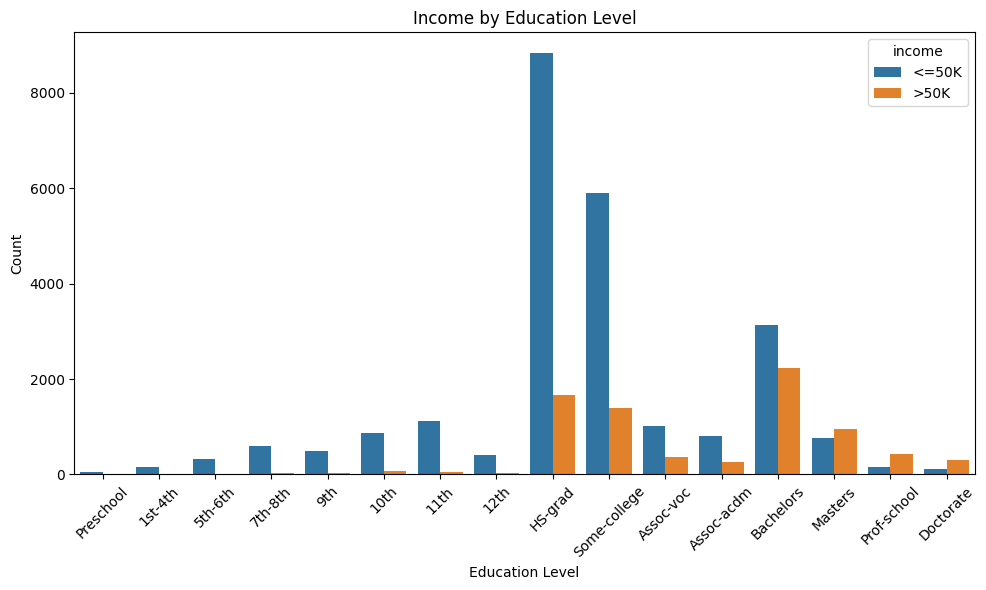

In [45]:
#impact of education level on income
education_order = [
    'Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th',
    'HS-grad', 'Some-college', 'Assoc-voc', 'Assoc-acdm', 
    'Bachelors', 'Masters', 'Prof-school', 'Doctorate'
]


df['education'] = pd.Categorical(df['education'], categories=education_order, ordered=True)
df = df.sort_values(by='education')
df.head()
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='education', hue='income', order=education_order)
plt.xticks(rotation=45)
plt.title("Income by Education Level")
plt.xlabel("Education Level")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



In [46]:
sorted_df = df.sort_values(by='age')  # Sort data by education level alphabetically
education_income_counts = df.groupby(['age', 'income']).size().reset_index(name='count')
print(education_income_counts)



     age income  count
0     17  <=50K    395
1     18  <=50K    550
2     19  <=50K    710
3     19   >50K      2
4     20  <=50K    753
..   ...    ...    ...
133   86  <=50K      1
134   87  <=50K      1
135   88  <=50K      3
136   90  <=50K     35
137   90   >50K      8

[138 rows x 3 columns]


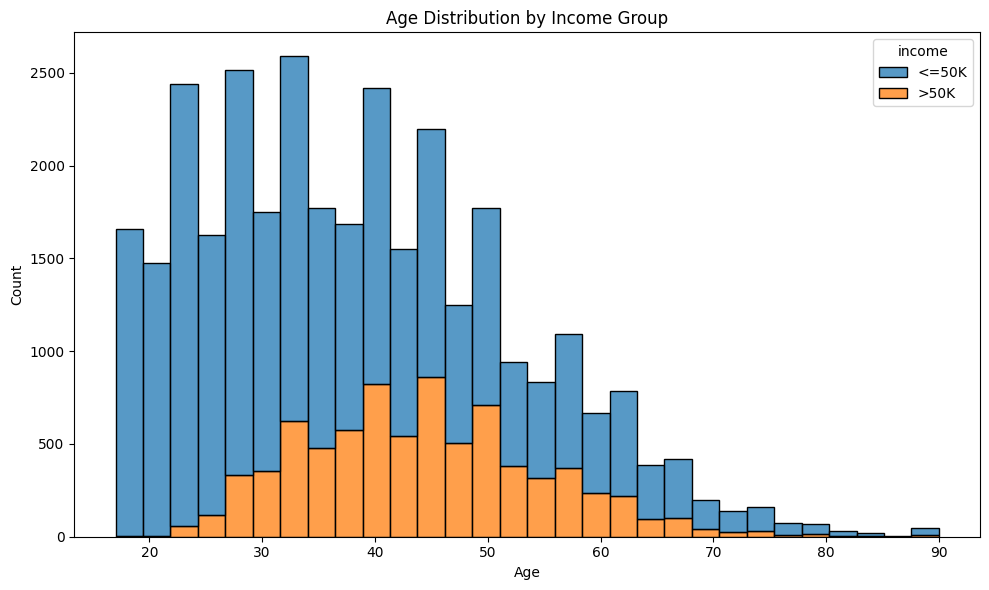

In [47]:
#Relationship between age and income
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='income', multiple='stack', bins=30)
plt.title("Age Distribution by Income Group")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [48]:
sorted_df = df.sort_values(by='sex')  # Sort data by education level alphabetically
education_income_counts = df.groupby(['sex', 'income']).size().reset_index(name='count')
print(education_income_counts)



      sex income  count
0  Female  <=50K   9592
1  Female   >50K   1179
2    Male  <=50K  15128
3    Male   >50K   6662


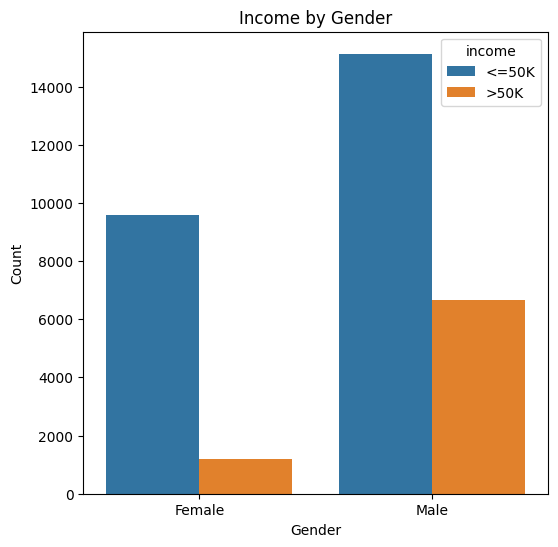

In [49]:
# Income disparity by gender
plt.figure(figsize=(6, 6))
sns.countplot(data=df, x='sex', hue='income')
plt.title("Income by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()


In [50]:
sorted_df = df.sort_values(by='race')  # Sort data by education level alphabetically
education_income_counts = df.groupby(['race', 'income']).size().reset_index(name='count')
print(education_income_counts)



                 race income  count
0  Amer-Indian-Eskimo  <=50K    275
1  Amer-Indian-Eskimo   >50K     36
2  Asian-Pac-Islander  <=50K    763
3  Asian-Pac-Islander   >50K    276
4               Black  <=50K   2737
5               Black   >50K    387
6               Other  <=50K    246
7               Other   >50K     25
8               White  <=50K  20699
9               White   >50K   7117


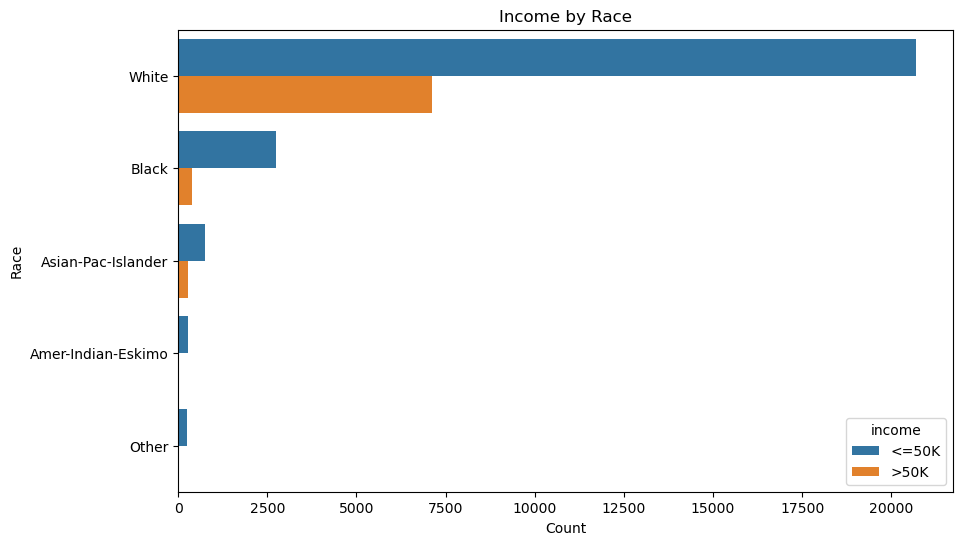

In [ ]:
# Race & Ethnic disparity in income
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='race', hue='income', order=df['race'].value_counts().index)
plt.title("Income by Race")
plt.xlabel("Count")
plt.ylabel("Race")
plt.show()


<h2> Data Preparation</h2>

In [51]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# DataFrame with numerical features
numerical_features = ["capital.gain", "capital.loss", "hours.per.week"]
sensitive_numerical_features = ["age", "race", "sex"]

df_numerical = df_adult[numerical_features]
df_sensitive_numerical = df_adult[sensitive_numerical_features]

# Mapping for "sex" (female = 0, Male = 1)
sex_mapping = {"Female": 0, "Male": 1}
df_sensitive_numerical["sex"] = df_sensitive_numerical["sex"].replace(sex_mapping)

# Mapping for "race" (White = 0, andere = 1)
race_mapping = {"White": 0, "Black": 1, "Asian-Pac-Islander": 1, "Amer-Indian-Eskimo": 1, "Other": 1}
df_sensitive_numerical["race"] = df_sensitive_numerical["race"].replace(race_mapping)

# StandardScaler für nicht-sensitive numerische Features
scaler = StandardScaler()
numerical_scaled = scaler.fit_transform(df_numerical)

# Create DataFrame with scaled numerical features
df_numerical_scaled = pd.DataFrame(numerical_scaled, columns=numerical_features)

# Add sensitive numerical features to DataFrame
df_numerical_scaled = pd.concat([df_numerical_scaled, df_sensitive_numerical.reset_index(drop=True)], axis=1)

# Choose categorical features
categorical_features = ["workclass", "education.num", "marital.status", "occupation", "native.country"]
df_categorical = df_adult[categorical_features]

# One-Hot-Encoding
df_categorical = pd.get_dummies(df_categorical, columns=["workclass", "marital.status", "occupation", "native.country"])

# Numerical and categorical features combined
df_adult_scaled = pd.concat([df_numerical_scaled, df_categorical.reset_index(drop=True)], axis=1)

# Define and decode target variable
target = df_adult["income"].copy()
target_mapping = {"<=50K": 0, ">50K": 1}
df_target = target.replace(target_mapping)

# Final DataFrame with all features
df_adult_scaled = pd.concat([df_adult_scaled, df_target.reset_index(drop=True)], axis=1)

df_adult_scaled.head()


C:\Users\manue\AppData\Local\Temp\ipykernel_2476\1404170423.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_sensitive_numerical["sex"] = df_sensitive_numerical["sex"].replace(sex_mapping)
C:\Users\manue\AppData\Local\Temp\ipykernel_2476\1404170423.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensitive_numerical["sex"] = df_sensitive_numerical["sex"].replace(sex_mapping)
C:\Users\manue\AppData\Local\Temp\ipykernel_2476\1404170423.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated an

,capital.gain,capital.loss,hours.per.week,age,race,sex,education.num,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia,income
0,-0.232795,10.593507,-0.023758,90,0,0,9,False,False,False,...,False,False,False,False,False,False,True,False,False,0
1,-0.232795,10.593507,-1.860423,82,0,0,9,False,False,False,...,False,False,False,False,False,False,True,False,False,0
2,-0.232795,10.593507,-0.023758,66,1,0,10,False,False,False,...,False,False,False,False,False,False,True,False,False,0
3,-0.232795,9.461864,-0.023758,54,0,0,4,False,False,False,...,False,False,False,False,False,False,True,False,False,0
4,-0.232795,9.461864,-0.023758,41,0,0,10,False,False,False,...,False,False,False,False,False,False,True,False,False,0


In [52]:
# Overview of all features
features = ["age", "workclass", "education-num", "marital-status", "occupation", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]

# Potentially sensitive features which we focus on
selected_sensitive_features = ["race", "sex"]

# Removal of sensitive features
remove = ["age"]

# Removal of selected sensitive features and create a separate decoded dataframe for the sensitive features
dataset, sensitive_data = remove_sensitive_features(df_adult_scaled, remove, selected_sensitive_features, features)

dataset.head()
sensitive_data.head()


,race,sex
0,White,Female
1,White,Female
2,Other,Female
3,White,Female
4,White,Female


<h2>Machine Learning</h2>

<h3>Decision Tree</h3>

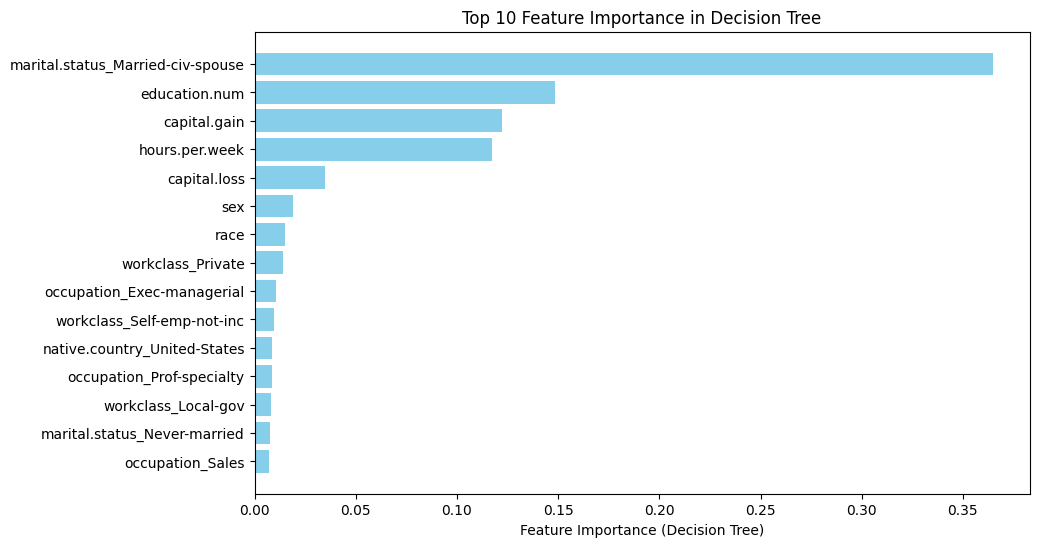

In [63]:
X = df_adult_scaled.drop(columns=["income"])
y = df_adult_scaled["income"]

# Train-Test-Split
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, y, sensitive_data, test_size=0.2, random_state=42)

# Class-Weights
class_weight = {
    0:1/6, # weight for negative class (<= 50K)
    1:5/6} # weight for positive class (>50K)

# Decision Tree
feature_names = X.columns  # Echte Namen der Features
# Decision Tree Modell trainieren
model_dt = DecisionTreeClassifier(random_state=42, class_weight=class_weight)
model_dt.fit(X, y)  

# Feature Importance 
feature_importance = model_dt.feature_importances_

# Sort by Importance
sorted_idx = np.argsort(feature_importance)[-15:]  
top_features = feature_names[sorted_idx]  # Echte Feature-Namen
top_importance = feature_importance[sorted_idx]  

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importance, color="skyblue")
plt.xlabel("Feature Importance (Decision Tree)")
plt.title("Top 10 Feature Importance in Decision Tree")
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.83      0.91      4976
           1       0.65      0.99      0.78      1537

    accuracy                           0.87      6513
   macro avg       0.82      0.91      0.84      6513
weighted avg       0.91      0.87      0.88      6513



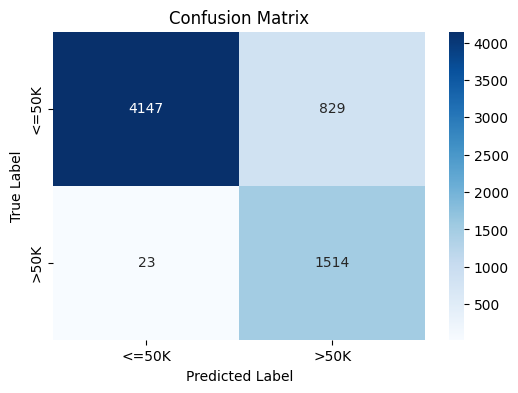

In [64]:
y_pred = model_dt.predict(X_test)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["<=50K", ">50K"], yticklabels=["<=50K", ">50K"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

<h3>Logistic Regression</h3>

Logistic Regression Accuracy: 0.7647781360356211
              precision    recall  f1-score   support

           0       0.95      0.73      0.83      4976
           1       0.50      0.89      0.64      1537

    accuracy                           0.76      6513
   macro avg       0.73      0.81      0.73      6513
weighted avg       0.85      0.76      0.78      6513



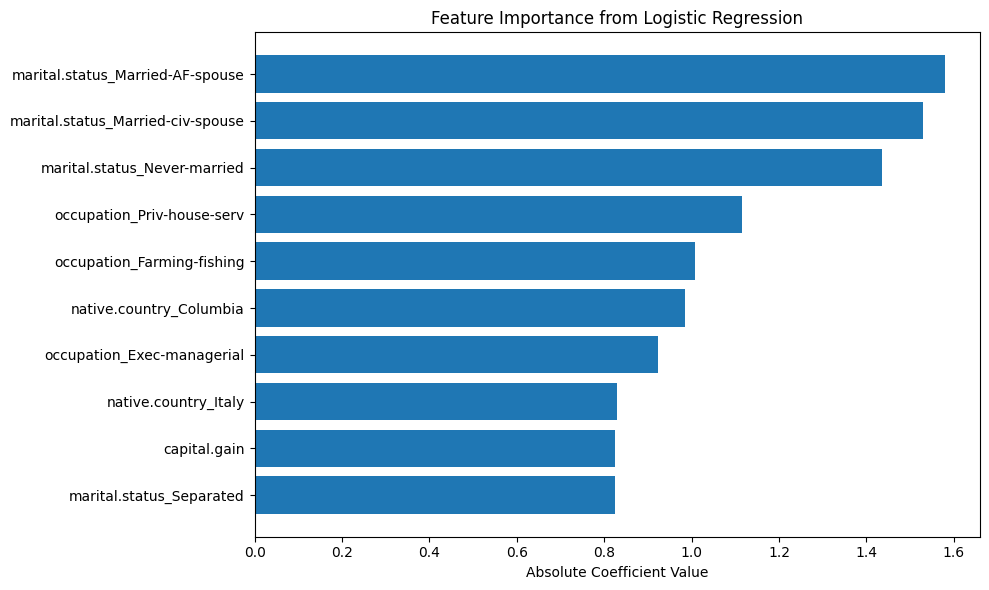

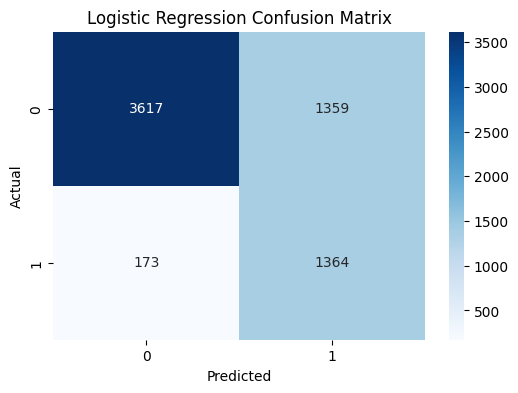

In [67]:
# Logistic Regression
# continue here :D (done)
log_model = LogisticRegression(max_iter=1000, random_state=42, class_weight=class_weight)
log_model.fit(X_train, y_train)

log_preds = log_model.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, log_preds))
print(classification_report(y_test, log_preds))


#confusion metrix func
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Get feature importance (coefficients)
importance = log_model.coef_[0]  # for binary classification, there's only one set of coefficients

# Create a DataFrame for easy sorting and plotting
feat_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(importance),
    'Coefficient': importance
}).sort_values(by='Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_importance['Feature'], feat_importance['Importance'])
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance from Logistic Regression')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()    




# confusion Matrix
plot_confusion(y_test, log_preds, "Logistic Regression Confusion Matrix")


<h3>Random Forest</h3>

Random Forest Accuracy: 0.8014739751266697
              precision    recall  f1-score   support

           0       0.91      0.82      0.86      4976
           1       0.56      0.74      0.64      1537

    accuracy                           0.80      6513
   macro avg       0.74      0.78      0.75      6513
weighted avg       0.83      0.80      0.81      6513



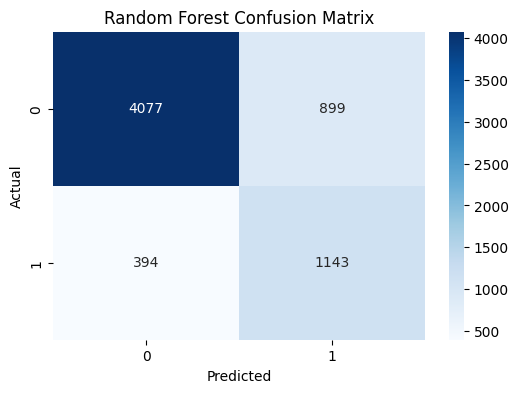

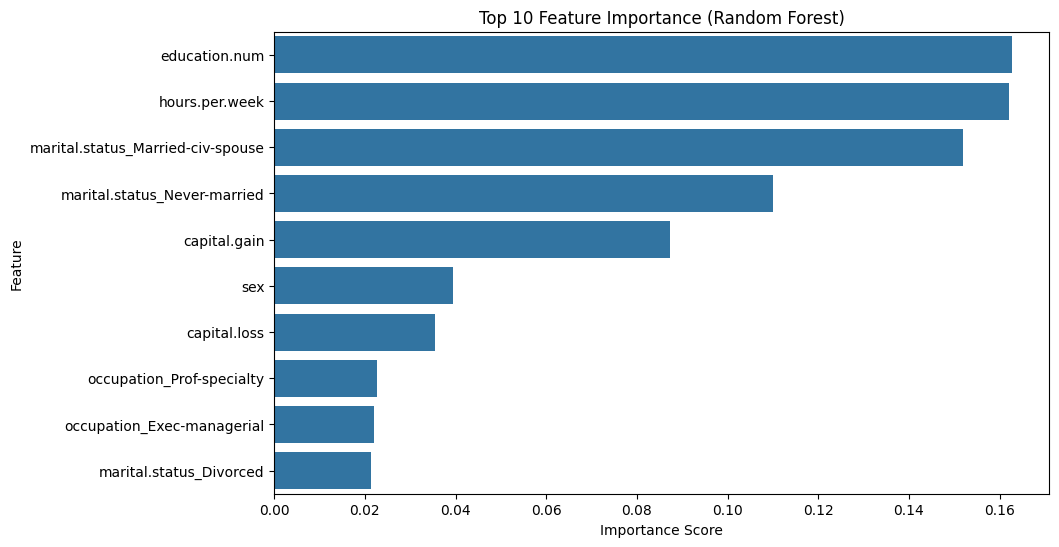

In [68]:
# Random Forest
# continue here :D (done)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight)
rf_model.fit(X_train, y_train)

rf_preds = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))


#  Confusion Matrix
plot_confusion(y_test, rf_preds, "Random Forest Confusion Matrix")

#  Feature Importance
importances = rf_model.feature_importances_
feat_names = X.columns

feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)

top_10_feat = feat_imp.head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_10_feat, y=top_10_feat.index)
plt.title("Top 10 Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


<h2>Fairness Evaluation</h2>

Differences for feature race:
 accuracy               0.103505
selection_rate         0.197994
false_positive_rate    0.143302
false_negative_rate    0.006170
dtype: float64


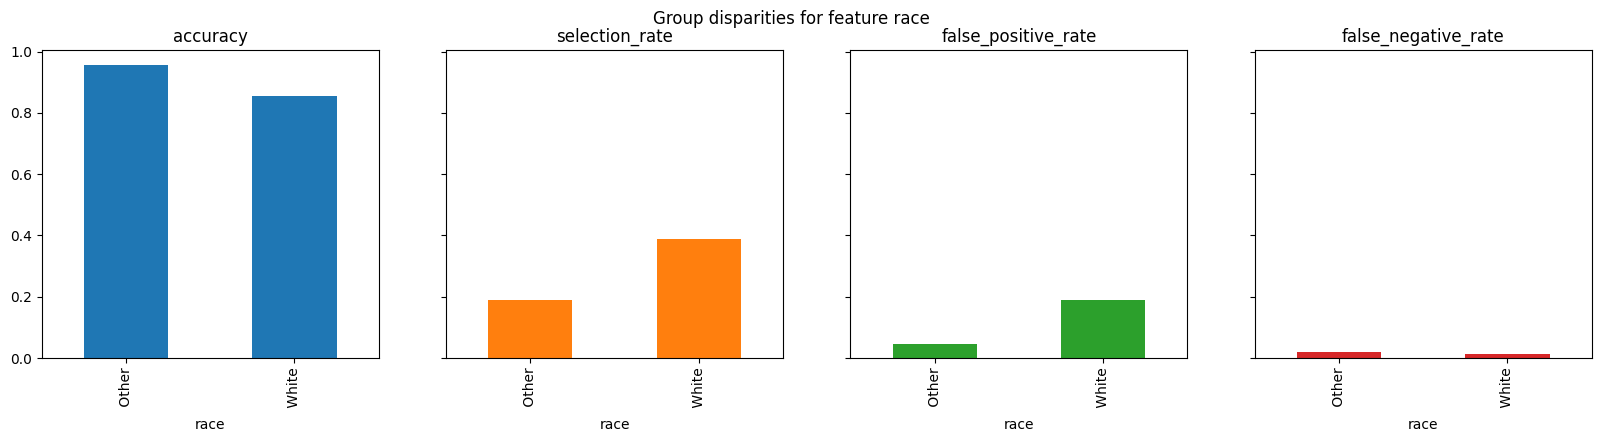

Differences for feature sex:
 accuracy               0.126724
selection_rate         0.313280
false_positive_rate    0.191448
false_negative_rate    0.007553
dtype: float64


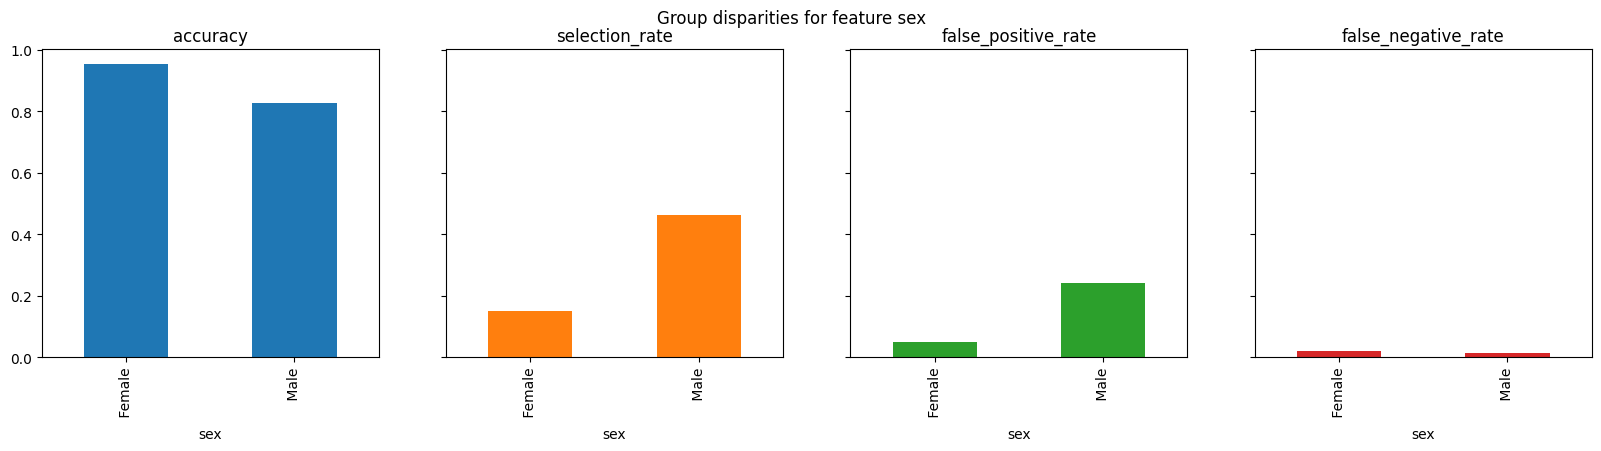

In [69]:
y_pred = model_dt.predict(X_test)

# Fairness Metrics to evaluate
fairness_metrics = {
    "accuracy": accuracy_score,
    "selection_rate": flm.selection_rate,
    "false_positive_rate": flm.false_positive_rate,
    "false_negative_rate": flm.false_negative_rate
}

# Plot Fairness evaluation
for feature in selected_sensitive_features:
    
    metricframe_unmitigated = flm.MetricFrame(
        metrics=fairness_metrics,
        y_true=y_test,
        y_pred=y_pred,
        sensitive_features=A_test[feature]
        )

    print(f"Differences for feature {feature}:\n {metricframe_unmitigated.difference()}")

    metricframe_unmitigated.by_group.plot.bar(
        subplots=True,
        sharey = all,
        title=(f"Group disparities for feature {feature}"), 
        layout=[1, len(fairness_metrics)], 
        figsize=[20, 4], 
        legend=None
    )
    plt.show()